## Setup

<font color='red'>**Warning**: if you work on Colab, upload the data zip on Google Drive in order to not have to upload it on your environment every time. It's also much faster to upload files on Google Drive than on Colab.</font>

## Create dataset from directory

In [62]:
%pip install pydot
%pip install tensorflow --upgrade
%pip install pip install scikit-image --upgrade
%pip install keras --upgrade
import tensorflow as tf
from tensorflow.keras.utils import plot_model

from pathlib import Path

IMG_WIDTH = IMG_HEIGHT = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/train'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/val'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/test'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


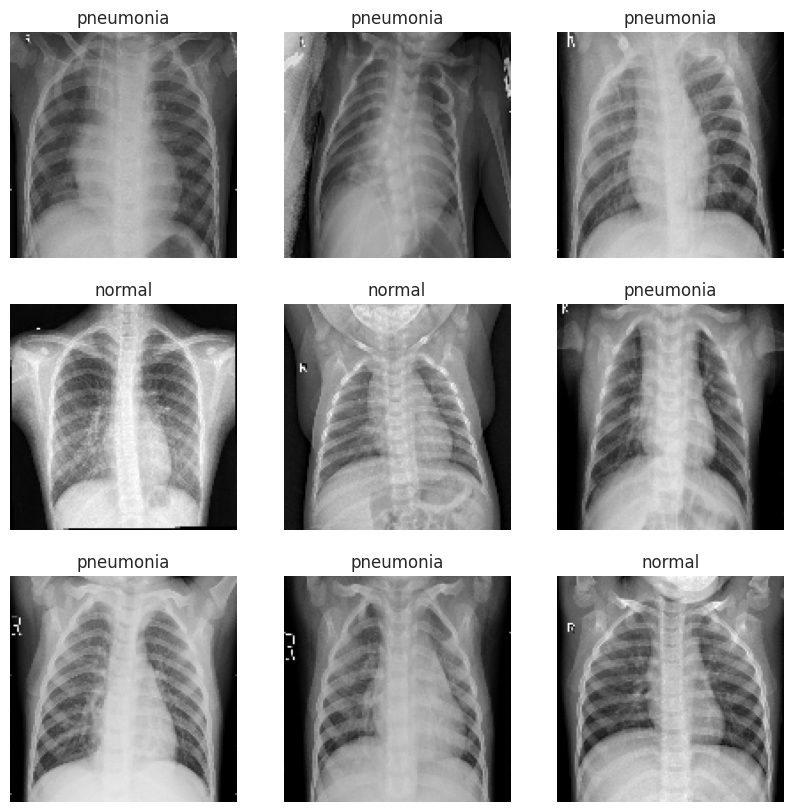

2024-05-08 18:06:03.028299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [63]:
import matplotlib.pyplot as plt

# Extract a batch of images and labels from the training dataset
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f'{train_ds.class_names[int(labels[i])]}')
        plt.axis('off')

    plt.show()

## Compute class weights

In [64]:
import numpy as np

# Initialize class counts
class_counts = np.zeros(len(train_ds.class_names), dtype=np.int64)

# Iterate over the dataset to count samples in each class
for images, labels in train_ds:
    flattened_labels = tf.cast(labels, dtype=tf.int64)  # Cast labels to int64
    flattened_labels = tf.reshape(flattened_labels, [-1])  # Flatten the labels
    class_counts += np.bincount(flattened_labels.numpy(), minlength=len(train_ds.class_names))

# Compute total number of samples
total_samples = np.sum(class_counts)

# Compute class weights
num_classes = len(train_ds.class_names)
class_weights = {i: total_samples / (num_classes * count) for i, count in enumerate(class_counts)}

2024-05-08 18:06:11.514130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [65]:
class_weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

## Create CNN model

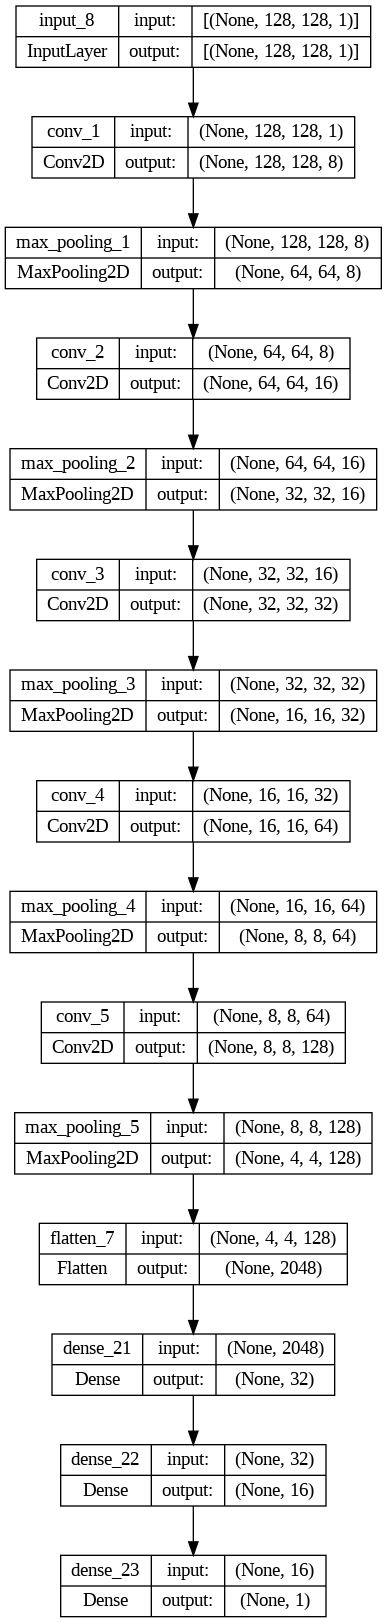

In [66]:
from tensorflow.keras import (
    layers,
    activations,
    Model,
    optimizers,
    losses
)

# Define CNN model
input = layers.Input((IMG_HEIGHT, IMG_WIDTH, 1))

# TODO: Complete this in order to have the same architecture
# as the one represented in the cell above
# note: use convolutions with relu and kernel size of 3.

conv_1 = layers.Conv2D(128, (3, 3), activation='relu')(input)
maxpool_1 = layers.MaxPooling2D((2, 2))(conv_1)
conv_2 = layers.Conv2D(64, (3, 3), activation='relu')(maxpool_1)
maxpool_2 = layers.MaxPooling2D((2, 2))(conv_2)
conv_3 = layers.Conv2D(32, (3, 3), activation='relu')(maxpool_2)
maxpool_3 = layers.MaxPooling2D((2, 2))(conv_3)
conv_4 = layers.Conv2D(16, (3, 3), activation='relu')(maxpool_3)
maxpool_4 = layers.MaxPooling2D((2, 2))(conv_4)
conv_5 = layers.Conv2D(8, (3, 3), activation='relu')(maxpool_4)
maxpool_5 = layers.MaxPooling2D((2, 2))(conv_5)
flattened = layers.Flatten()(maxpool_5)
dense_1 = layers.Dense(32, activation='relu')(flattened)
dense_2 = layers.Dense(16, activation='relu')(dense_1)
output = layers.Dense(1, activation='sigmoid')(dense_2)

cnn = Model(inputs=input, outputs=output)

# Compile CNN model
cnn.compile(optimizer=optimizers.Adam(0.001), loss=losses.BinaryCrossentropy(), metrics=['accuracy'])

In [67]:
#from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(cnn, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [68]:
history = cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights
)

Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.6755 - loss: 0.7277 - val_accuracy: 0.6875 - val_loss: 0.6199
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.8909 - loss: 0.2452 - val_accuracy: 0.8125 - val_loss: 0.4146
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.9307 - loss: 0.1715 - val_accuracy: 0.8750 - val_loss: 0.3075
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.9351 - loss: 0.1765 - val_accuracy: 0.7500 - val_loss: 0.3665
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.9412 - loss: 0.1554 - val_accuracy: 0.7500 - val_loss: 0.3201
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.9494 - loss: 0.1301 - val_accuracy: 0.6875 - val_loss: 0.5160
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.9574 - loss: 0.1122 - val_accuracy: 0.6250 - val_loss: 0.4308
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.9619 - loss: 0.1098 - val_accuracy: 0.8750 - v

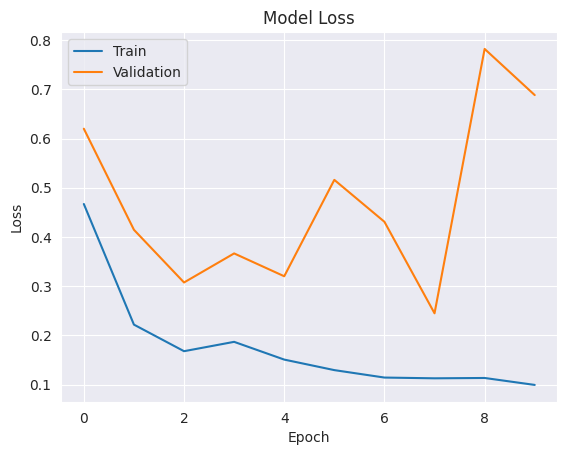

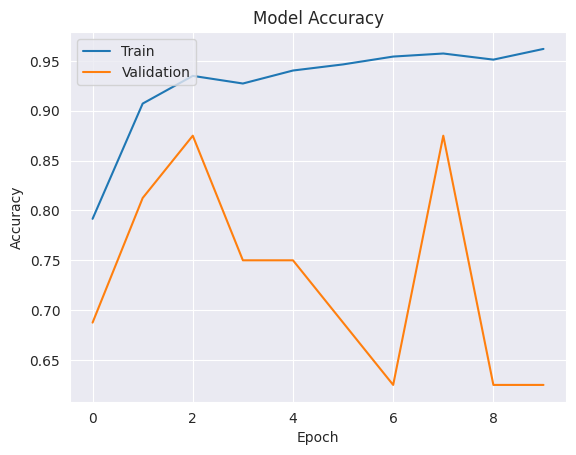

In [69]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

val_images = []
val_labels = []

for img, label in val_ds:
  val_images.append(img)
  val_labels.append(label)

val_images = np.vstack(val_images)
val_labels = np.vstack(val_labels).squeeze().astype(int)

# TODO: create confusion matrix and compute metrics here and do the same for test set

from sklearn.metrics import confusion_matrix
pred = cnn.predict(val_images)
pred = np.round(pred).astype(int)
confusion_matrix(val_labels, pred)



# Compute confusion matrix
val_predictions = cnn.predict(val_images)
val_predictions = np.round(val_predictions).astype(int)
val_cm = confusion_matrix(val_labels, val_predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


2024-05-08 18:43:52.764235: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
